## Concept

**Generate captions for the SVHN dataset using a convnet attention model**  
Similar to Show, Attend and Tell and example from attention mechanism pytorch tutorials.  
Use the last layer feature map by the convnet as encoder outputs.  
Feed encoder outputs to a attention based RNN network.  


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.transforms as T
from torchvision import datasets
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

from livelossplot import PlotLosses
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [ ]:
SOS = 10

transform = T.Compose([
                        T.Resize(128),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
svhn_path = "/home/shubham/SVHN/"
svhn_train = datasets.SVHN(svhn_path, download=False, transform=transform)
svhn_trainloader = DataLoader(svhn_train, shuffle=True, batch_size=1)

In [ ]:
def see_example():
    svhn_path = "/home/shubham/SVHN/"
    svhn_train = datasets.SVHN(svhn_path, download=False)
    image, caption = svhn_train[2000]
    plt.imshow(image)
    print caption
    print image.size
see_example()

### Using a ResNet34 model for image representations  


In [ ]:
def SubModel(model, layers):
    return nn.Sequential(*list(model.children())[:layers])

In [ ]:
model = models.squeezenet1_0(pretrained=False)
encoder = SubModel(model,-1) ## remove last Linear Layer
print model

In [ ]:
images, captions = next(iter(svhn_trainloader))

Take only feature layer and remove last linear layer

In [89]:
out = encoder(images)
out.shape

torch.Size([1, 512, 7, 7])

### Decoder model with attention  
See example [PyTorch Translation Seq2Seq with attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#visualizing-attention)  
Average the 512\*49 final feature vector to 512\*1 feature vector for the hidden state representation but apply attention on the 521\*49 matrix  

In [90]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size = 128,vocab_size = 11, dropout_p=0.1, feature_size=(512,7*7)):
        """
        vocab_size : length of vocabulary, 10 numbers + 1 start digit
        """
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout_p = dropout_p
        self.feature_size = feature_size
        self.embedding_size = embedding_size
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.feature_size[0])
        self.attn_combine = nn.Linear(self.embedding_size + self.feature_size[1], self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size ,self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        
    def forward(self, input, hidden, encoder_output):
        """
        encoder_output -> matrix of size feature_size
        hidden -> matrix of size (feature_size[0],1)
        """
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0],hidden[0]),1)),dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_output.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]),1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output , hidden = self.gru(output, hidden)
        
        output = F.softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)
        

In [91]:
decoder = AttnDecoderRNN(512)

In [ ]:
hidden = out.view(1,512,-1).mean(2).unsqueeze(0)
hidden.shape

In [93]:
out = out.squeeze(0).view(512,-1)

In [94]:
inp = torch.LongTensor([5])
vals = decoder(inp, hidden, out)

In [95]:
vals[0]

tensor([[0.1176, 0.0435, 0.0466, 0.0290, 0.2613, 0.1337, 0.0253, 0.0852, 0.1000,
         0.1443, 0.0136]], grad_fn=<SoftmaxBackward>)

## Training Code

In [96]:
def train(image, caption, encoder, decoder, encoder_optim, decoder_optim, criteria_loss):
    

    loss = 0
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    
    encoder_output = encoder(image).squeeze(0).view(512,-1)
    encoder_output = encoder_output.cuda()
    decoder_input = torch.LongTensor([SOS])
    decoder_hidden = encoder_output.view(1,512,-1).mean(2).unsqueeze(0)
    
    decoder_input=decoder_input.cuda()
    decoder_hidden=decoder_hidden.cuda()
    decoder_output , decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_output)
    
    loss += criteria_loss(decoder_output, caption)
    
    loss.backward()
    
    encoder_optim.step()
    decoder_optim.step()
    
    return loss.item(), torch.argmax(decoder_output,dim=1)

In [97]:
def toOneHot(val):
    oh = torch.zeros(11)
    oh[val] = 1
    return oh.unsqueeze(0).long()

In [101]:
image, captions = next(iter(svhn_trainloader))
#captions = toOneHot(captions)

tensor([2])


In [108]:
liveloss = PlotLosses()
loss = []
loss_ = 0
encoder=encoder.cuda()
decoder=decoder.cuda()
encoder_optim = optim.Adam(encoder.parameters())
decoder_optim = optim.Adam(decoder.parameters())

encoder.train()
decoder.train()
train_iter = 10
correct = 0
criteria = nn.NLLLoss()
for i in range(1,30000):
    image, captions = next(iter(svhn_trainloader))
    image=image.cuda()
    captions=captions.cuda()
    _loss , out = train(image, captions, encoder, decoder, encoder_optim, decoder_optim, criteria)
    loss_ += _loss
    correct = correct + (captions == out)[0]
    #print correct
    avg_correct = 100 * (correct.cpu().numpy() / float(i))

    if i % train_iter == 0:
        print avg_correct
        liveloss.update({'log_loss':loss_ / train_iter, 'accuracy':avg_correct})
        liveloss.draw()
        loss.append(loss_ / train_iter)
        loss_=0

KeyboardInterrupt: 

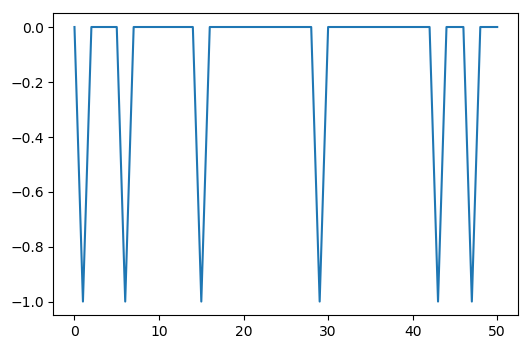

In [39]:
plt.plot(loss)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
